# Inaugural Project

> **Note the following:** 
> 1. This is an example of how to structure your **inaugural project**.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `inauguralproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [32]:
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
import Inauguralproject2024

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1

The initial endowment is:
$$\omega_1^A=0.8$$
$$\omega_2^A=0.3$$

Now we illustrate the set C (the Pareto improvements relative to the endowment) in the Edgeworth box

In [34]:
# Define utility functions
def u_A(x_A1, x_A2, alpha):
    return x_A1 **alpha * x_A2 ** (1-alpha)

def u_B(x_B1, x_B2, beta):
    return x_B1 ** beta * x_B2 ** (1-beta)

In [31]:
# Define endowment points
omega_A1 = 0.8
omega_A2 = 0.3
omega_B1 = 1 - omega_A1
omega_B2 = 1 - omega_A2

In [33]:
# Define alpha and beta
alpha = 1/3
beta = 2/3

In [37]:
# Define the grid for x_A1 and x_A2
N = 75
x_A1_values = [i/N for i in range(N+1)]
x_A2_values = [i/N for i in range(N+1)]

In [40]:
# Initialize list to store Pareto improvements
pareto_improvements = []

# Iterate over combinations
for x_A1 in x_A1_values:
    for x_A2 in x_A2_values:
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Check if the combination is a Pareto improvement
        if (u_A(x_A1, x_A2, alpha) > u_A(omega_A1, omega_A2, alpha) and
            u_B(x_B1, x_B2, beta) > u_B(omega_B1, omega_B2, beta)):
            pareto_improvements.append((x_A1, x_A2))

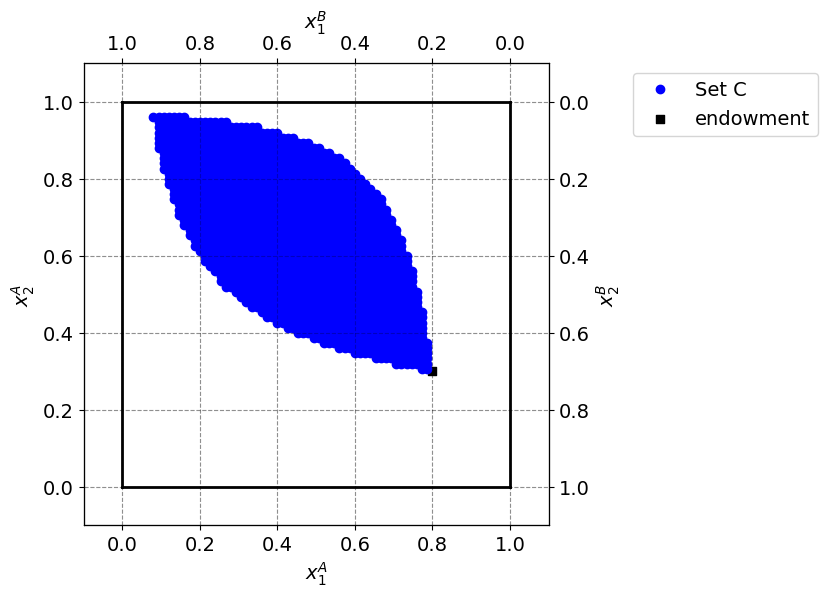

In [35]:

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


from Exchange import ExchangeEconomyClass


model = ExchangeEconomyClass()


par = model.par

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# Extract x_A1 and x_A2 from pareto_improvements
pareto_improvements_x_A1 = [allocation[0] for allocation in pareto_improvements]
pareto_improvements_x_A2 = [allocation[1] for allocation in pareto_improvements]

# Plot the set C
ax_A.plot(pareto_improvements_x_A1, pareto_improvements_x_A2, 'bo', label='Set C')

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));


# Question 2

For the price set $p_1$ we calculate the error in the market clearing conditions:

In [36]:
# Define the grid for p1 and p2
N = 75
P1 = [0.5+2*i/N for i in range(N+1)]
p2 = 1  # Numeraire is p2 = 1

In [63]:
# Define alpha and beta
alpha = 1/3
beta = 2/3

# Initialize lists to store errors
errors_1 = []
errors_2 = []
p_1 = []

# Iterate over each value of p1
for p1 in P1:
    # Calculate demand for both goods for consumer A
    x_A1_star = alpha * (p1 * omega_A1 + omega_A2 * p2) / p1
    x_A2_star = (1 - alpha) * (p1 * omega_A1 + omega_A2 * p2) / p2
    
    # Calculate demand for both goods for consumer B
    x_B1_star = beta * (p1 * omega_B1 + omega_B2* p2) / p1
    x_B2_star = (1 - beta) * (p1 * omega_B1 + omega_B2 * p2) / p2

# Calculate errors in market clearing conditions
    error_1 = x_A1_star - omega_A1 + x_B1_star - omega_B1
    error_2 = x_A2_star - omega_A2 + x_B2_star - omega_B2
    
    # Append errors and price to the lists 
    errors_1.append(error_1)
    errors_2.append(error_2)
    p_1.append(p1)

# Print errors
print("Errors in market clearing conditions:")
for i, p1 in enumerate(P1):
    print(f"For p1 = {p1}:")
    print(f"Error 1: {errors_1[i]}")
    print(f"Error 2: {errors_2[i]}")
    print()


Errors in market clearing conditions:
For p1 = 0.5:
Error 1: 0.533333333333333
Error 2: -0.2666666666666666

For p1 = 0.5266666666666666:
Error 1: 0.47594936708860747
Error 2: -0.25066666666666654

For p1 = 0.5533333333333333:
Error 1: 0.42409638554216855
Error 2: -0.23466666666666652

For p1 = 0.58:
Error 1: 0.3770114942528735
Error 2: -0.2186666666666665

For p1 = 0.6066666666666667:
Error 1: 0.33406593406593377
Error 2: -0.2026666666666665

For p1 = 0.6333333333333333:
Error 1: 0.2947368421052629
Error 2: -0.18666666666666654

For p1 = 0.66:
Error 1: 0.2585858585858586
Error 2: -0.1706666666666664

For p1 = 0.6866666666666666:
Error 1: 0.22524271844660193
Error 2: -0.1546666666666665

For p1 = 0.7133333333333334:
Error 1: 0.19439252336448576
Error 2: -0.1386666666666665

For p1 = 0.74:
Error 1: 0.16576576576576557
Error 2: -0.12266666666666659

For p1 = 0.7666666666666666:
Error 1: 0.13913043478260856
Error 2: -0.10666666666666658

For p1 = 0.7933333333333333:
Error 1: 0.11428571428

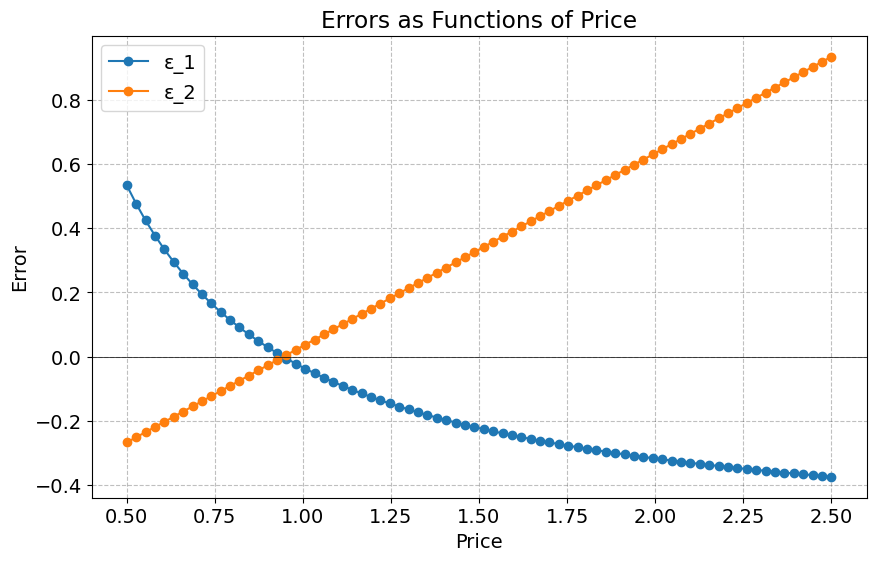

In [65]:
 
plt.figure(figsize=(10, 6))
plt.plot(p_1, errors_1, label='ε_1', marker='o')
plt.plot(p_1, errors_2, label='ε_2', marker='o')
plt.xlabel('Price')
plt.ylabel('Error')
plt.title('Errors as Functions of Price')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


# Question 3

Calculating the market clearing price:

In [41]:
# Define demand functions for both consumers
def demand_A(p1):
    x_A1 = alpha * (p1 * omega_A1 + omega_A2) / p1
    return x_A1

def demand_B(p1):
    x_B1 = beta * (p1 * omega_B1 + omega_B2) / p1
    return x_B1

# Define supply functions
def supply_A(p1):
    return omega_A1

def supply_B(p1):
    return omega_B1

# Define a function to calculate the market clearing price
def market_clearing_price():
    # Define a range of prices
    prices = np.linspace(0.5, 2.5, num=1000)
    
    # Iterate over prices to find the one where quantity demanded equals quantity supplied
    for p1 in prices:
        if demand_A(p1) + demand_B(p1) == supply_A(p1) + supply_B(p1):
            return p1
    
    return None  # Return None if no market clearing price is found

# Find the market clearing price
clearing_price = market_clearing_price()

# Print the result
if clearing_price is not None:
    print("The market clearing price is:", clearing_price)
else:
    print("No market clearing price found in the given range of prices.")



The market clearing price is: 0.9444444444444444


# Question 4a

Assuming that A chooses the price to maximize own utility, we can find the allocation if only prices in $P_1$ can be chosen:

In [39]:
# Define the utility function
def u_A(x_B1, x_B2, alpha):
    return (1-x_B1) ** alpha * (1-x_B2) ** (1 - alpha)

# Initialize variables to store the optimal allocation and utility
optimal_x_A1 = 0
optimal_x_A2 = 0
max_utility = float('-inf')
optimal_p1 = None

# Loop through all possible allocations of x_B1 and x_B2
for p1 in P1:
    x_B1 = beta * (p1 * omega_B1 + omega_B2) / p1
    x_B2 = (1 - beta) * (p1 * omega_B1 +  omega_B2)
    
    # Ensure that x_B1 and x_B2 are between 0 and 1
    if 0 <= x_B1 <= 1 and 0 <= x_B2 <= 1:
        current_utility = u_A(x_B1, x_B2, alpha)
        # Check if current allocation gives higher utility
        if current_utility > max_utility:
            max_utility = current_utility
            optimal_x_A1 = 1- x_B1
            optimal_x_A2 = 1- x_B2
            optimal_p1 = p1

# Print the results
print("Optimal allocation of x_A1:", optimal_x_A1)
print("Optimal allocation of x_A2:", optimal_x_A2)
print("Optimal p1:", optimal_p1)
print("Maximum Utility for A:", max_utility)

Optimal allocation of x_A1: 0.619316843345112
Optimal allocation of x_A2: 0.6408888888888888
Optimal p1: 1.8866666666666667
Maximum Utility for A: 0.633615985237553


# Question 4b

The allocation if any positive price can be chosen: 

In [43]:
import numpy as np


#Import class
from fireb import ExchangeEconomyClass

#Define the model
model = ExchangeEconomyClass()
par = model.par


#Define a range of values for p1
p1_values = np.arange(0.1, 1000, 1/100)

#Define the maximum utility and the optimal price
maxutilityA_4b = float('-inf')
Optimalp1_4b = None

#Loop through different prices 
for p1 in p1_values:
    x1B4b = model.demand_B1(p1)
    x2B4b = model.demand_B2(p1)
    x1A4b = max(0, 1 - x1B4b)
    x2A4b = max(0, 1 - x2B4b)
    util_A = model.utility_A(x1A4b,x2A4b)

    #Save the p1 that yields the highest utility 
    if util_A > maxutilityA_4b:
        maxutilityA_4b = util_A
        Optimalp1_4b = p1

#Find the allocation given the optimal price
x1A_4b = 1 - model.demand_B1(Optimalp1_4b)
x2A_4b = 1 - model.demand_B2(Optimalp1_4b)
x1B_4b = model.demand_B1(Optimalp1_4b)
x2B_4b = model.demand_B2(Optimalp1_4b)

#Use the optimal allocation to find the utility of consumer B given the chosen p1
util_B = model.utility_B(x1B_4b, x2B_4b)


#Print the optimal p1, the allocation that this price yields and the utility for both consumers
print("Chosen p1:", Optimalp1_4b)
print("Utility for consumer A:", maxutilityA_4b)
print("Utility for consumber B:", util_B)
print("Allocation of X1A:", x1A_4b)
print("Allocation of X2A:", x2A_4b)
print("Allocation of X1B:", x1B_4b)
print("Allocation of X2B:", x2B_4b)

Chosen p1: 1.8999999999999992
Utility for consumer A: 0.6336208378614051
Utility for consumber B: 0.3725232906283801
Allocation of X1A: 0.6210526315789473
Allocation of X2A: 0.64
Allocation of X1B: 0.3789473684210527
Allocation of X2B: 0.36


# Question 5a

In [44]:
# Define the utility function
def u_A(x_A1, x_A2, alpha):
    return (x_A1) ** alpha * (x_A2) ** (1 - alpha)

# Initialize variables to store the optimal allocation and utility
optimal_allocation = None
max_utility_A = float('-inf')

# Iterate over combinations
for x_A1 in x_A1_values:
    for x_A2 in x_A2_values:
        # Calculate x_B1 and x_B2
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Check if the allocation satisfies the constraints
        if 0 <= x_A1 <= 1 and 0 <= x_A2 <= 1 and 0 <= x_B1 <= 1 and 0 <= x_B2 <= 1:
            # Calculate utilities for A and B
            utility_A = u_A(x_A1, x_A2, alpha)
            utility_B = u_B(x_B1, x_B2, beta)
            
            # Check if B's utility is not worse than endowment
            if utility_B >= u_B(omega_B1, omega_B2, beta):
                # Check if this allocation maximizes A's utility
                if utility_A > max_utility_A:
                    max_utility_A = utility_A
                    optimal_allocation = (x_A1, x_A2, x_B1, x_B2)

# Print the optimal allocation and utilities
if optimal_allocation is not None:
    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Utility for A:", max_utility_A)
    print("Utility for B:", u_B(optimal_allocation[2], optimal_allocation[3], beta))
else:
    print("No feasible allocation found.")


Optimal allocation:
x_A1 = 0.56
x_A2 = 0.8533333333333334
x_B1 = 0.43999999999999995
x_B2 = 0.1466666666666666
Utility for A: 0.7415523509091093
Utility for B: 0.30507896071427915


# Question 5b

In [46]:
# Initialize variables to store the optimal allocation and utility
optimal_allocation = None
max_utility_A = float('-inf')

# Iterate over combinations
for x_A1 in np.linspace(0, 1, num=1000):
    for x_A2 in np.linspace(0, 1, num=1000):
        # Calculate x_B1 and x_B2
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Calculate utilities for A and B
        utility_A = u_A(x_A1, x_A2, alpha)
        utility_B = u_B(x_B1, x_B2, beta)
            
        # Check if this allocation maximizes A's utility and utility for B is not worse than the endowment
        if utility_A > max_utility_A and utility_B >= u_B(omega_B1, omega_B2, beta):
            max_utility_A = utility_A
            optimal_allocation = (x_A1, x_A2, x_B1, x_B2)

# Print the optimal allocation and utilities
if optimal_allocation is not None:
    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Utility for A:", max_utility_A)
    print("Utility for B:", u_B(optimal_allocation[2], optimal_allocation[3], beta))
else:
    print("No feasible allocation found.")


Optimal allocation:
x_A1 = 0.5695695695695696
x_A2 = 0.8488488488488488
x_B1 = 0.4304304304304304
x_B2 = 0.1511511511511512
Utility for A: 0.743137485688798
Utility for B: 0.30367273291585534


# Question 6a

In [42]:
# Initialize variables to store the optimal allocation and utility
optimal_allocation = None
max_aggregate_utility = float('-inf')

# Iterate over combinations
for x_A1 in np.linspace(0, 1, num=1000):
    for x_A2 in np.linspace(0, 1, num=1000):
        # Calculate x_B1 and x_B2
        x_B1 = 1 - x_A1
        x_B2 = 1 - x_A2
        
        # Calculate utilities for A and B
        utility_A = u_A(x_A1, x_A2, alpha)
        utility_B = u_B(x_B1, x_B2, beta)
        
        # Calculate aggregate utility
        aggregate_utility = utility_A + utility_B
            
        # Check if this allocation maximizes aggregate utility
        if aggregate_utility > max_aggregate_utility:
            max_aggregate_utility = aggregate_utility
            optimal_allocation = (x_A1, x_A2, x_B1, x_B2)

# Print the optimal allocation and utilities
if optimal_allocation is not None:
    print("Optimal allocation:")
    print("x_A1 =", optimal_allocation[0])
    print("x_A2 =", optimal_allocation[1])
    print("x_B1 =", optimal_allocation[2])
    print("x_B2 =", optimal_allocation[3])
    print("Aggregate utility:", max_aggregate_utility)
    print("Utility for A:", u_A(optimal_allocation[0], optimal_allocation[1], alpha))
    print("Utility for B:", u_B(optimal_allocation[2], optimal_allocation[3], beta))
else:
    print("No feasible allocation found.")


Optimal allocation:
x_A1 = 0.0
x_A2 = 0.0
x_B1 = 1.0
x_B2 = 1.0
Aggregate utility: 2.0
Utility for A: 1.0
Utility for B: 1.0


# Question 6b

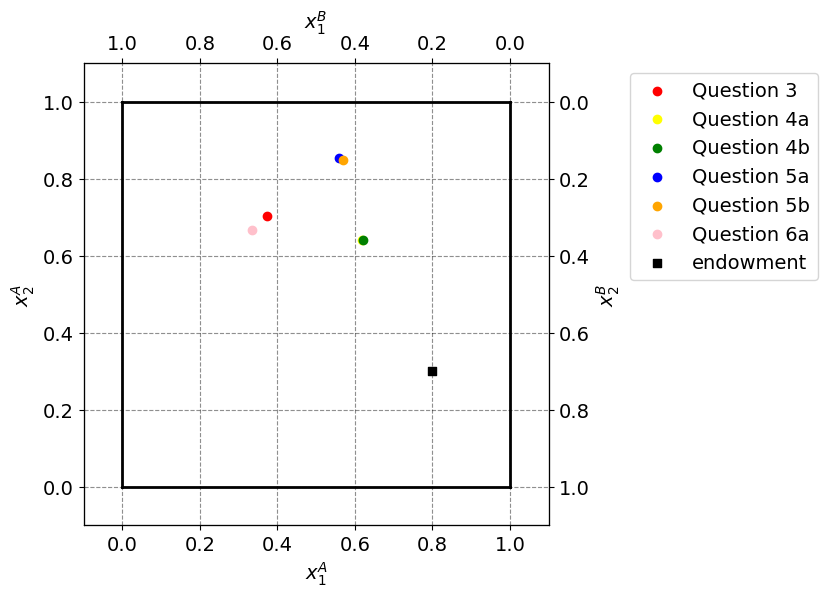

In [48]:

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


from Exchange import ExchangeEconomyClass


model = ExchangeEconomyClass()


par = model.par

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()


opgave_3x_A1 = 0.37254902
opgave_3x_A2 = 0.703703704
opgave_4ax_A1 = 0.619316843345112
opgave_4ax_A2 = 0.640888888
opgave_4bx_A1 = 0.6210526315789473
opgave_4bx_A2 = 0.64
opgave_5ax_A1 = 0.56
opgave_5ax_A2 = 0.8533333
opgave_5bx_A1 = 0.56956957
opgave_5bx_A2 = 0.848848849
opgave_6ax_A1 = 0.333333333
opgave_6ax_A2 = 0.6666666667

ax_A.scatter(opgave_3x_A1,opgave_3x_A2, marker='o',color='red',label='Question 3')
ax_A.scatter(opgave_4ax_A1,opgave_4ax_A2, marker='o',color='yellow',label='Question 4a')
ax_A.scatter(opgave_4bx_A1,opgave_4bx_A2, marker='o',color='green',label='Question 4b')
ax_A.scatter(opgave_5ax_A1,opgave_5ax_A2, marker='o',color='blue',label='Question 5a')
ax_A.scatter(opgave_5bx_A1,opgave_5bx_A2, marker='o',color='orange',label='Question 5b')
ax_A.scatter(opgave_6ax_A1,opgave_6ax_A2, marker='o',color='pink',label='Question 6a')
# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));



**Discussion of the different allocations:**

The plot above shows the different allocations plotted in the same edgeworth box. 
We see that the allocation from (3) is almost the same as the social planner allocation from (6a). 
Since an efficient market economy will deliver an optimal alocation this makes sense, and the only 
friction between the allocations is caused by the discrete jumps in the set P1.
The allocation from (4a) and (4b) is almost identical which again makes sense as the optimal price is included in P1.
Loosening the constraint from prices only in the set P1 to all positive prices therefore only makes a difference due to the the discrete nature of the set P1.
The allocation from (5a) and (5b) favours consumer A more strongly as seen by the comparisons of utility below. 
This is due to the fact that A can choose the consumption of B directly, thereby getting a more favourable allocation.

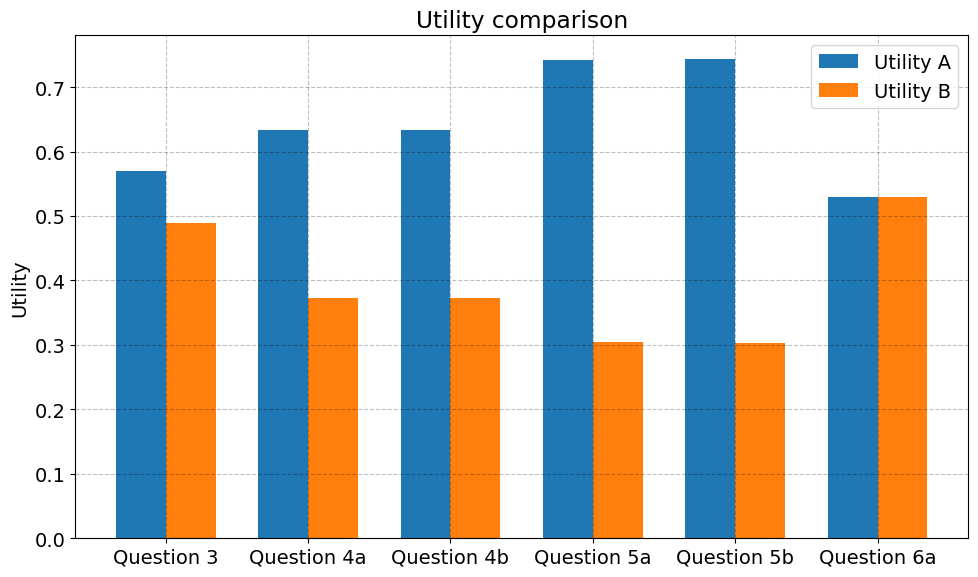

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Define the allocation results from questions 3)-6)
allocations = {
    'Question 3': {'x_A1': 0.37254902, 'x_A2': 0.703703704, 'x_B1': 0.62745098, 'x_B2': 0.296296296},
    'Question 4a': {'x_A1': 0.619316843345112, 'x_A2': 0.640888888, 'x_B1': (1-0.619316843345112), 'x_B2': (1-0.640888888)},
    'Question 4b': {'x_A1': 0.6210526315789473, 'x_A2': 0.64, 'x_B1': (1-0.6210526315789473), 'x_B2': (1-0.64)},
    'Question 5a': {'x_A1': 0.56, 'x_A2': 0.8533333, 'x_B1': 0.44, 'x_B2': 0.14666667},
    'Question 5b': {'x_A1': 0.56956957, 'x_A2': 0.848848849, 'x_B1': 0.43043043, 'x_B2': 0.151151151},
    'Question 6a': {'x_A1': 0.333333333, 'x_A2': 0.6666666667, 'x_B1': 0.6666666667, 'x_B2': 0.333333333}
}

# Plot utility values
utility_A = []
utility_B = []
labels = []

for label, allocation in allocations.items():
    x_A1, x_A2, x_B1, x_B2 = allocation.values()
    utility_A.append(x_A1 ** (1/3) * x_A2 ** (2/3))
    utility_B.append(x_B1 ** (2/3) * x_B2 ** (1/3))
    labels.append(label)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, utility_A, width, label='Utility A')
rects2 = ax.bar(x + width/2, utility_B, width, label='Utility B')

ax.set_ylabel('Utility')
ax.set_title('Utility comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()

plt.show()

# Question 7

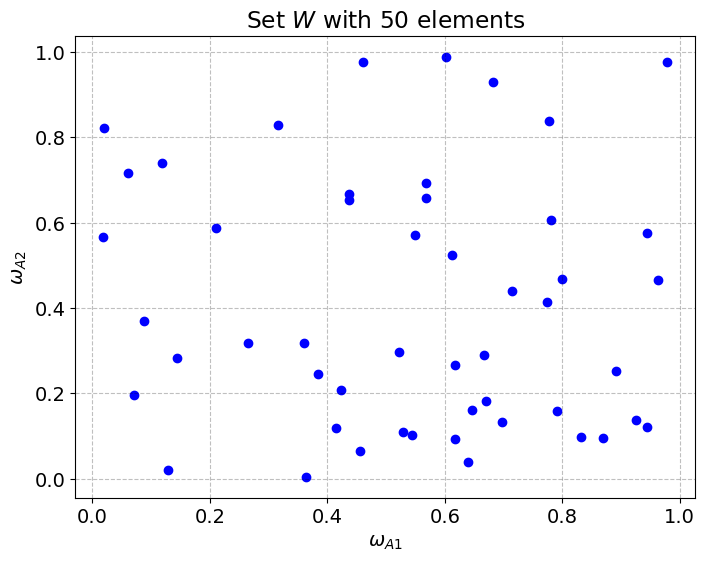

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(0)

# Number of elements in the set W
num_elements = 50

# Generate random values for omega_A1 and omega_A2
omega_A1_values = np.random.uniform(0, 1, num_elements)
omega_A2_values = np.random.uniform(0, 1, num_elements)

# Plot the set W
plt.figure(figsize=(8, 6))
plt.scatter(omega_A1_values, omega_A2_values, color='blue')
plt.title('Set $W$ with 50 elements')
plt.xlabel('$\omega_{A1}$')
plt.ylabel('$\omega_{A2}$')
plt.grid(True)
plt.show()


The plot above shows the distribution of the 50 random endowments for consumer A. Each point represents an allocation of endowments for consumer A, that is an endowment of good 1 and good 2. Indirectly, this also defines the endowments for consumber B, as these are just 1-WAi for i=1,2. 

# Question 8

Set W (Endowments for Agent A of Good 1 and Good 2, and Endowments for Agent B of Good 1 and Good 2):
[[0.67781654 0.27000797 0.32218346 0.72999203]
 [0.73519402 0.96218855 0.26480598 0.03781145]
 [0.24875314 0.57615733 0.75124686 0.42384267]
 [0.59204193 0.57225191 0.40795807 0.42774809]
 [0.22308163 0.95274901 0.77691837 0.04725099]
 [0.44712538 0.84640867 0.55287462 0.15359133]
 [0.69947928 0.29743695 0.30052072 0.70256305]
 [0.81379782 0.39650574 0.18620218 0.60349426]
 [0.8811032  0.58127287 0.1188968  0.41872713]
 [0.88173536 0.69253159 0.11826464 0.30746841]
 [0.72525428 0.50132438 0.27474572 0.49867562]
 [0.95608363 0.6439902  0.04391637 0.3560098 ]
 [0.42385505 0.60639321 0.57614495 0.39360679]
 [0.0191932  0.30157482 0.9808068  0.69842518]
 [0.66017354 0.29007761 0.33982646 0.70992239]
 [0.61801543 0.4287687  0.38198457 0.5712313 ]
 [0.13547406 0.29828233 0.86452594 0.70171767]
 [0.56996491 0.59087276 0.43003509 0.40912724]
 [0.57432525 0.65320082 0.42567475 0.34679918]
 [0.6

C:\Users\pwarr\AppData\Local\Temp\ipykernel_29940\3332572569.py:26: RuntimeWarning: invalid value encountered in power
  return x1**alpha_A * x2**(1-alpha_A)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_29940\3332572569.py:35: RuntimeWarning: invalid value encountered in power
  return x1**alpha_B * x2**(1-alpha_B)
c:\Users\pwarr\Programmering\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_29940\3332572569.py:26: RuntimeWarning: invalid value encountered in scalar power
  return x1**alpha_A * x2**(1-alpha_A)
C:\Users\pwarr\AppData\Local\Temp\ipykernel_29940\3332572569.py:35: RuntimeWarning: invalid value encountered in scalar power
  return x1**alpha_B * x2**(1-alpha_B)
c:\Users\pwarr\Programmering\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration 

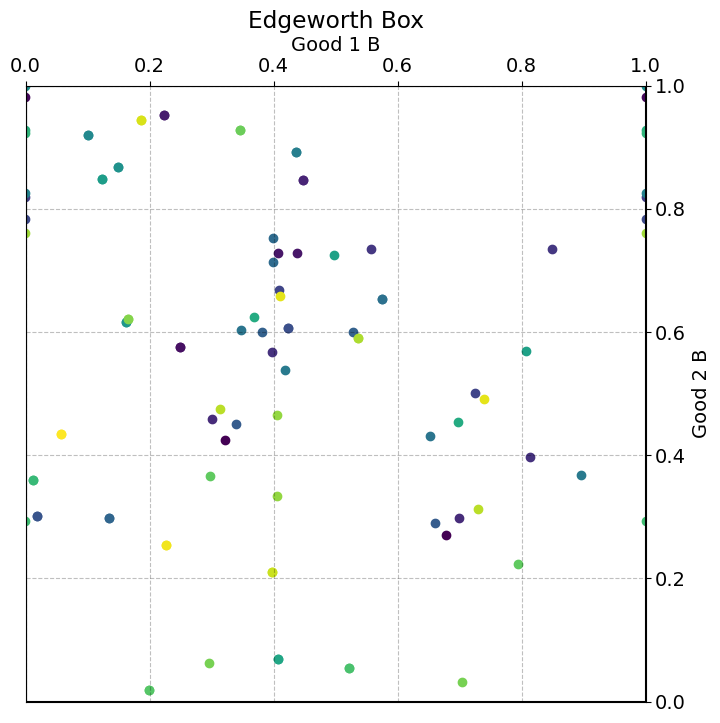

In [49]:
import numpy as np

# Set the number of vectors
num_samples = 50

# Generate random endowment vectors for agent A
endowments_A = np.random.rand(num_samples, 2)

# Calculate endowments for agent B
endowments_B = 1 - endowments_A

# Combine endowments for agent A and agent B into a single set W
endowments_W = np.concatenate((endowments_A, endowments_B), axis=1)

# Print the set W
print("Set W (Endowments for Agent A of Good 1 and Good 2, and Endowments for Agent B of Good 1 and Good 2):")
print(endowments_W)

# Given parameters
alpha_A = 1/3
alpha_B = 2/3
price_good2 = 1  # Price of good 2

# Utility and demand functions for agent A
def utility_A(x1, x2):
    return x1**alpha_A * x2**(1-alpha_A)

def demand_A(p1, p2, omega_A1, omega_A2):
    x1 = alpha_A * omega_A1 / p1
    x2 = (1 - alpha_A) * omega_A2 / p2
    return x1, x2

# Utility and demand functions for agent B
def utility_B(x1, x2):
    return x1**alpha_B * x2**(1-alpha_B)

def demand_B(p1, p2, omega_B1, omega_B2):
    x1 = alpha_B * omega_B1 / p1
    x2 = (1 - alpha_B) * omega_B2 / p2
    return x1, x2

# Market allocation function for both agents
def market_allocation(p1, p2, omega_A1, omega_A2):
    x1_A, x2_A = demand_A(p1, p2, omega_A1, omega_A2)
    x1_B, x2_B = demand_B(p1, p2, 1 - omega_A1, 1 - omega_A2)  # Endowments for agent B are 1 - endowments for agent A
    
    # Ensure total amount of each good is 1
    total_good1 = x1_A + x1_B
    total_good2 = x2_A + x2_B
    scaling_factor = 1 / max(total_good1, total_good2)
    x1_A *= scaling_factor
    x1_B *= scaling_factor
    x2_A *= scaling_factor
    x2_B *= scaling_factor
    
    # Ensure utility for each agent is at least the same as in the original endowment
    if utility_A(x1_A, x2_A) < utility_A(omega_A1, omega_A2):
        x1_A, x2_A = omega_A1, omega_A2
    if utility_B(x1_B, x2_B) < utility_B(1 - omega_A1, 1 - omega_A2):
        x1_B, x2_B = 1 - omega_A1, 1 - omega_A2

    return x1_A, x2_A, x1_B, x2_B

# Solve for market allocations for each endowment vector in set W
market_allocations = []
for endowment in endowments_W:
    # Set p2 = 1
    p2 = 1
    
    # Initial guess for p1
    p1_guess = 1
    
    # Define the market clearing condition function
    def market_clearing_condition(p1):
        x1_A, x2_A, _, _ = market_allocation(p1, p2, endowment[0], endowment[1])
        return x1_A + endowment[0] - 1  # Market clearing condition
    
    # Solve for p1 using fsolve
    from scipy.optimize import fsolve
    p1_solution = fsolve(market_clearing_condition, p1_guess)
    
    # Calculate market allocation using the solved p1
    x1_A, x2_A, x1_B, x2_B = market_allocation(p1_solution[0], p2, endowment[0], endowment[1])
    
    # Append market allocation to the list
    market_allocations.append([x1_A, x2_A, x1_B, x2_B])

# Convert market allocations to NumPy array
market_allocations = np.array(market_allocations)

import matplotlib.pyplot as plt
import numpy as np

# Extract market allocations for each agent
x1_A = market_allocations[:, 0]
x2_A = market_allocations[:, 1]
x1_B = market_allocations[:, 2]
x2_B = market_allocations[:, 3]

# Determine the number of vectors
num_vectors = len(x1_A)

# Generate a colormap with a color for each vector
colors = plt.cm.viridis(np.linspace(0, 1, num_vectors))

# Plotting Edgeworth box
plt.figure(figsize=(8, 8))
plt.xlabel("Good 1 A")
plt.ylabel("Good 2 A")
plt.title("Edgeworth Box")

# Plot market allocations for agent A
for i in range(num_vectors):
    plt.scatter(x1_A[i], x2_A[i], color=colors[i], label=f'Agent A - Vector {i}')

# Plot market allocations for agent B (inverted axes)
for i in range(num_vectors):
    plt.scatter(1 - x1_B[i], 1 - x2_B[i], color=colors[i], label=f'Agent B - Vector {i}')

# Set axis limits to ensure axes go from 0 to 1
plt.xlim(0, 1)
plt.ylim(0, 1)

# Plot axes
plt.plot([0, 1], [0, 0], color='black')  # x-axis
plt.plot([0, 0], [0, 1], color='black')  # y-axis
plt.plot([1, 1], [0, 1], color='black')  # Second x-axis for Agent B
plt.plot([0, 1], [1, 1], color='black')  # Second y-axis for Agent B

# Add right and top axes
plt.gca().yaxis.set_label_position("right")
plt.gca().xaxis.set_label_position("top")
plt.gca().yaxis.tick_right()
plt.gca().xaxis.tick_top()
plt.xlabel("Good 1 B")
plt.ylabel("Good 2 B")

plt.grid(True)
plt.show()
